In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

**Separate out experiments from one file that contains multiple experiments**


In [19]:
# read data

exp_no = 104
last_file_no = 152
file_name = str(exp_no)+"_SHT_SMD.txt"

file_path = "../data/01_raw/" + file_name
# print(file_path)
df = pd.read_csv(file_path, sep=',' , usecols=['timestamp','SHT40_temp','SHT40_Humidity','A1_Sensor', 'A1_Resistance'])
timestamp_data = df['timestamp'].values 
sht40_temp_data = df['SHT40_temp'].values
sht40_humidity_data = df['SHT40_Humidity'].values 
a1_sensor_data = df['A1_Sensor'].values 
a1_r_data = df['A1_Resistance'].values

In [4]:
df.head()

,timestamp,SHT40_temp,SHT40_Humidity,A1_Sensor,A1_Resistance
0,1681654579047,29.62,41.82,2741.0,1285096.75
1,1681654579097,29.61,41.83,2739.0,1286144.50
2,1681654579147,29.59,41.83,2740.0,1285620.37
3,1681654579197,29.60,41.81,2734.0,1288771.00
4,1681654579247,29.59,41.82,2737.0,1287194.00


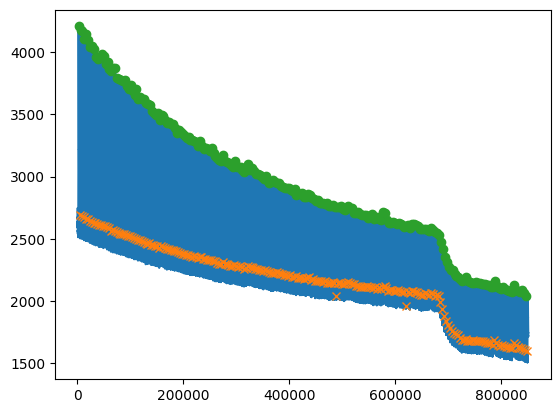

In [5]:
# Find peaks and their properties
peaks, properties = find_peaks(a1_sensor_data, width=50, height=1)

# Get the peak heights
peak_heights = properties['peak_heights']

# Initialize lists to hold the smaller and larger peaks
smaller_peaks = []
larger_peaks = []

# Iterate over the peaks
for i in range(len(peaks) - 1):
    # If the next peak is smaller, label the current peak as a larger peak
    if peak_heights[i] > peak_heights[i + 1]:
        larger_peaks.append(peaks[i])
        smaller_peaks.append(peaks[i + 1])

# Convert lists to numpy arrays for indexing
smaller_peaks = np.array(smaller_peaks)
larger_peaks = np.array(larger_peaks)

# Plot data
plt.plot(a1_sensor_data)

# Overlay smaller peaks with 'x'
plt.plot(smaller_peaks, a1_sensor_data[smaller_peaks], "x")

# Overlay larger peaks with 'o'
plt.plot(larger_peaks, a1_sensor_data[larger_peaks], "o")

plt.show()

*Save Partially Processed Data into Individual Files at Interim Folder*

In [26]:
print(len(exp_no))
print(len(relative_time))
print(len(data_c))
print(len(data_rh))
print(len(data_v))
print(len(data_r))

3643
3640
3640
3640
3640
3640


In [27]:
# Iterate over the smaller_peaks array
# create a df to store the data
# timestamp,SHT40_temp,SHT40_Humidity,A1_Sensor,A1_Resistance
df_stacked = pd.DataFrame(columns=['exp_no', 'timestamp', 'SHT40_temp', 'SHT40_Humidity', 'A1_Sensor', 'A1_Resistance'])

for i in range(len(smaller_peaks) - 1):
    # Get the data of between the current and next smaller peak
    data_c = sht40_temp_data[smaller_peaks[i]:smaller_peaks[i + 1]]
    data_rh = sht40_humidity_data[smaller_peaks[i]:smaller_peaks[i + 1]]
    data_v = a1_sensor_data[smaller_peaks[i]:smaller_peaks[i + 1]]
    data_r = a1_r_data[smaller_peaks[i]:smaller_peaks[i + 1]]
    
    timestamps = timestamp_data[smaller_peaks[i]:smaller_peaks[i + 1]]
    relative_time = timestamps - timestamps[0]
    # create a new header called experiment number with each iteration being 1 experiment and add it to the data
    exp_no = pd.Series(i, index=range(len(data_r)))
    # create a new df with the data
    df_labelled = pd.DataFrame({'exp_no': exp_no, 'timestamp': relative_time, 'SHT40_temp': data_c, 'SHT40_Humidity': data_rh, 'A1_Sensor': data_v, 'A1_Resistance': data_r})
    # concat each df_labelled to the df_stacked
    df_stacked = pd.concat([df_stacked, df_labelled])



/var/folders/mm/nclx10yn5lnb99y4352wnw6w0000gn/T/ipykernel_3613/2345746944.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_stacked = pd.concat([df_stacked, df_labelled])


In [28]:
# write df_stacked to csv
df_stacked.to_csv("../data/02_intermediate/stacked_data.csv", index=False)

In [31]:
# Create data file name in sequence

exp_folder = str(exp_no) + '/'
folder_path = f'../data/interim/' + exp_folder 
# Check if the directory exists and create it if it doesn't
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Iterate over the smaller_peaks array
for i in range(len(smaller_peaks) - 1):
    # Get the data between the current and next smaller peak
    data = a1_r_data[smaller_peaks[i]:smaller_peaks[i + 1]]
    timestamps = timestamp_data[smaller_peaks[i]:smaller_peaks[i + 1]]
    relative_time = timestamps - timestamps[0]

    # Write the data to a file
    with open(f'{folder_path}{i + last_file_no}.txt', 'w') as f:
        # Write the header
        f.write('timestamp,relative_time,resistance_ohm\n')    
        # Write the data
        for t, rt, value in zip(timestamps, relative_time, data):
            f.write(f'{t},{rt},{value}\n')